# Intro to Spark with NBA statistics

In [1]:
%matplotlib inline
from functools import reduce  # For Python 3.x
import os

from matplotlib import pyplot as plt
import numpy
import pandas as pd
import seaborn

from pyspark.sql.functions import col, lit
from pyspark.sql import DataFrame
from pyspark.sql.types import DoubleType, IntegerType, StringType

In [2]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

# Create SparkSession

In [3]:
spark = SparkSession(sc)

# Read NBA data

In [4]:
# dfs = []
# source_dir = 'BasketballStats/data'
# column_names = ['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'yr']
# beg, end = [1970,2016]
# for i in range(beg,end+1):
#     _df = pd.read_csv(os.path.join(source_dir,'leagues_NBA_{}_per_game_per_game.csv'.format(i)))
#     _df['yr'] = i
#     _df.columns = column_names
#     dfs.append(_df)
# df_all = pd.concat(dfs, ignore_index=True)

# df_all = df_all[df_all.Age != 'Age']
# df_all = df_all[df_all.PF != 'PF']
# df_all.to_csv('all_data.csv')

In [5]:
# saved above file to hdfs
df = spark.read.option('header','true').csv("/BasketballStats/all_data.csv").filter('FG != "FG"')

# Cleansing

In [6]:
print(df.head())
print(df.count())
print(df.schema.names)
print(df.dtypes)

Row(_c0='0', Rk='1', Player='Zaid Abdul-Aziz', Pos='PF', Age='23', Tm='MIL', G='80', GS=None, MP='20.5', FG='3.0', FGA='6.8', FG%='.434', 3P=None, 3PA=None, 3P%=None, 2P='3.0', 2PA='6.8', 2P%='.434', eFG%='.434', FT='1.5', FTA='2.3', FT%='.643', ORB=None, DRB=None, TRB='7.5', AST='0.8', STL=None, BLK=None, TOV=None, PF='2.1', PTS='7.4', yr='1970')
17534
['_c0', 'Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'yr']
[('_c0', 'string'), ('Rk', 'string'), ('Player', 'string'), ('Pos', 'string'), ('Age', 'string'), ('Tm', 'string'), ('G', 'string'), ('GS', 'string'), ('MP', 'string'), ('FG', 'string'), ('FGA', 'string'), ('FG%', 'string'), ('3P', 'string'), ('3PA', 'string'), ('3P%', 'string'), ('2P', 'string'), ('2PA', 'string'), ('2P%', 'string'), ('eFG%', 'string'), ('FT', 'string'), ('FTA', 'string'), ('FT%', 'string'), ('ORB', 'strin

In [7]:
dtype_dict = {'Player' : StringType, 'Pos' : StringType, 'Tm' : StringType, 'Age' : IntegerType, 'G' : IntegerType, 'GS' : IntegerType, 'yr' : IntegerType}

df2 = df.fillna('0')

for c in df2.schema.names[6:]:
    dtype = DoubleType if c not in dtype_dict.keys() else dtype_dict[c]
    df2 = df2.withColumn(c,df2[c].cast(dtype()))
df2.cache()

DataFrame[_c0: string, Rk: string, Player: string, Pos: string, Age: string, Tm: string, G: int, GS: int, MP: double, FG: double, FGA: double, FG%: double, 3P: double, 3PA: double, 3P%: double, 2P: double, 2PA: double, 2P%: double, eFG%: double, FT: double, FTA: double, FT%: double, ORB: double, DRB: double, TRB: double, AST: double, STL: double, BLK: double, TOV: double, PF: double, PTS: double, yr: int]

# Summary stats
* number distinct players
* most points per game

In [59]:
fga = df2.groupby('FG').count().sort('FG', ascending = False).toPandas()

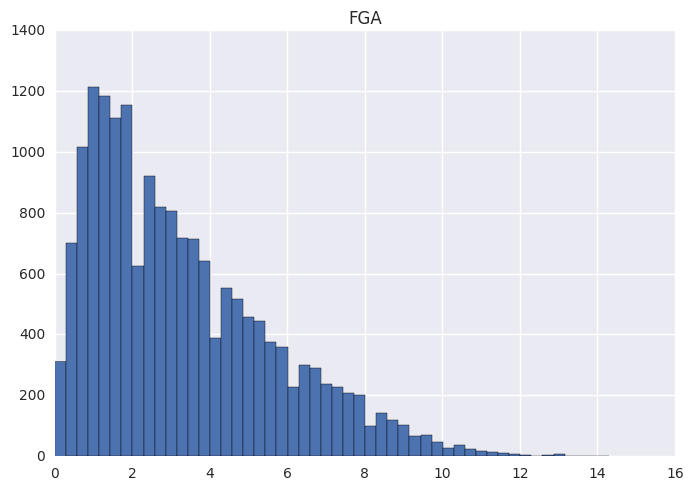

In [81]:
plt.title('FGA')
_=plt.hist(fga['FG'], weights = fga['count'], bins = 50)

In [75]:
pts = df2.groupby('PTS').count().sort('PTS', ascending = False).toPandas()

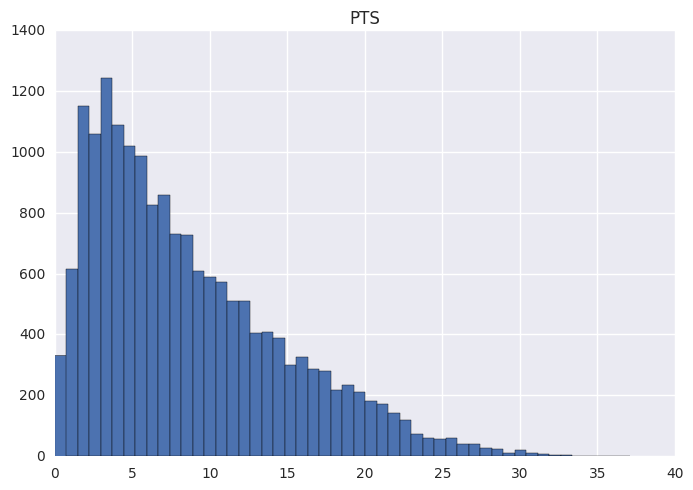

In [84]:
plt.title('PTS')
_=plt.hist(pts['PTS'], weights = pts['count'], bins = 50)

# Most efficient scorers

In [69]:
pts_fgp = df2.select('Player','Yr','FG%', 'FGA', 'FTA', 'PTS').toPandas()

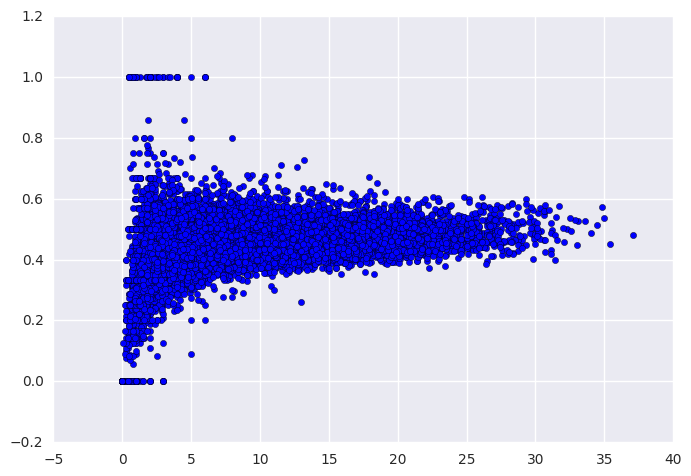

In [70]:
plt.scatter(pts_fgp['PTS'],pts_fgp['FG%'])

In [30]:
import numpy as np
from bokeh.io import output_notebook

In [43]:
output_notebook()

Loading BokehJS ...

In [66]:
x = pts_fgp.PTS
y = pts_fgp['FG%']
player = pts_fgp.Player + '-' + pts_fgp.Yr.astype('str')

In [68]:
from collections import OrderedDict
import numpy as np

from bokeh.plotting import *
from bokeh.models import HoverTool

output_notebook()

source = ColumnDataSource(
    data=dict(
        x=x.values,
        y=y.values,
        label=player.values)
)
TOOLS="crosshair,pan,wheel_zoom,box_zoom,reset,hover"
p = figure(title="simple line example", tools=TOOLS)
p.circle('x', 'y', color="#2222aa", line_width=2, source=source)

hover =p.select(dict(type=HoverTool))
hover.tooltips = OrderedDict([
    ("index", "$index"),
    ("(xx,yy)", "(@x, @y)"),
    ("label", "@label"),
])

show(p)

Loading BokehJS ...

ERROR:/home/hadoop/conda/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource(id='6482b411-9732-43e1-96ae-b9d0c4154944', ...)
ERROR:/home/hadoop/conda/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource(id='f9816782-ccbe-4c5b-ad68-28926cbe704c', ...)


# True shooting %

In [33]:
pts_fgp_orig = df2.select('Player','Yr','FG%', 'FGA', 'FTA', 'PTS', 'G', 'Tm').filter('Yr > 2000 and G > 50 and Yr > 2012')
pts_fgp = df2.select('Player','Yr','FG%', 'FGA', 'FTA', 'PTS', 'G', 'Tm').filter('Yr > 2000 and G > 50 and Yr > 2012').toPandas()

In [35]:
pts_fgp_orig.freqItems(['Player','Tm']).toPandas()

,Player_freqItems,Tm_freqItems
0,"[Cody Zeller, Tyler Zeller]","[TOR, HOU, CHA, PHO, SAS, GSW, OKC, TOT, CLE, ..."


In [50]:
def calc_ts_per(pts,fga,fta):
    return pts/(2*(fga + (0.44*fta)))

calc_ts_per(24.9,17.1,5.3)
pts_fgp['TS%'] = calc_ts_per(pts_fgp.PTS,pts_fgp.FGA,pts_fgp.FTA)

In [113]:
pts_fgp['TS%'] = calc_ts_per(pts_fgp.PTS,pts_fgp.FGA,pts_fgp.FTA)

## Map using Spark

In [53]:
# using Spark
def calc_ts_per(row):
    pts,fga,fta = row.PTS,row.FGA,row.FTA
    return pts/(2*(fga + (0.44*fta)))

ts2 = pts_fgp_orig.rdd.map(calc_ts_per).collect()

list(zip(pts_fgp['TS%'], ts2))

#end testing

[(0.49554013875123881, 0.4955401387512388),
 (0.52749360613810736, 0.5274936061381074),
 (0.53100463056170721, 0.5310046305617072),
 (0.47918043621943152, 0.4791804362194315),
 (0.60022026431718067, 0.6002202643171807),
 (0.48602009611183933, 0.48602009611183933),
 (0.52202517162471396, 0.522025171624714),
 (0.50894216133942161, 0.5089421613394216),
 (0.54848320693391106, 0.5484832069339111),
 (0.56177575947384906, 0.5617757594738491),
 (0.53030303030303028, 0.5303030303030303),
 (0.53684448462929479, 0.5368444846292948),
 (0.47272163670179784, 0.47272163670179784),
 (0.55592250110083663, 0.5559225011008366),
 (0.52549194991055459, 0.5254919499105546),
 (0.5447585394581862, 0.5447585394581862),
 (0.50154320987654322, 0.5015432098765432),
 (0.51401018922852992, 0.5140101892285299),
 (0.52201543349977308, 0.5220154334997731),
 (0.56843267108167772, 0.5684326710816777),
 (0.4351610095735422, 0.4351610095735422),
 (0.53466076696165188, 0.5346607669616519),
 (0.63218390804597702, 0.63218390

In [114]:
x = pts_fgp.PTS
y = pts_fgp['TS%']
player = pts_fgp.Player + '-' + pts_fgp.Yr.astype('str')

In [115]:
from collections import OrderedDict
import numpy as np

from bokeh.plotting import *
from bokeh.models import HoverTool

output_notebook()

source = ColumnDataSource(
    data=dict(
        x=x.values,
        y=y.values,
        label=player.values)
)
TOOLS="crosshair,pan,wheel_zoom,box_zoom,reset,hover"
p = figure(title="TS%", tools=TOOLS)
p.circle('x', 'y', color="#2222aa", line_width=2, source=source)

hover =p.select(dict(type=HoverTool))
hover.tooltips = OrderedDict([
    ("index", "$index"),
    ("(xx,yy)", "(@x, @y)"),
    ("label", "@label"),
])

show(p)

Loading BokehJS ...

ERROR:/home/hadoop/conda/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource(id='6482b411-9732-43e1-96ae-b9d0c4154944', ...)
ERROR:/home/hadoop/conda/lib/python3.5/site-packages/bokeh/core/validation/check.py:E-1000 (COLUMN_LENGTHS): ColumnDataSource column lengths are not all the same: ColumnDataSource(id='f9816782-ccbe-4c5b-ad68-28926cbe704c', ...)


# Sampling and subsampling

In [61]:
df2.randomSplit([1.,2.])

[DataFrame[_c0: string, Rk: string, Player: string, Pos: string, Age: string, Tm: string, G: int, GS: int, MP: double, FG: double, FGA: double, FG%: double, 3P: double, 3PA: double, 3P%: double, 2P: double, 2PA: double, 2P%: double, eFG%: double, FT: double, FTA: double, FT%: double, ORB: double, DRB: double, TRB: double, AST: double, STL: double, BLK: double, TOV: double, PF: double, PTS: double, yr: int],
 DataFrame[_c0: string, Rk: string, Player: string, Pos: string, Age: string, Tm: string, G: int, GS: int, MP: double, FG: double, FGA: double, FG%: double, 3P: double, 3PA: double, 3P%: double, 2P: double, 2PA: double, 2P%: double, eFG%: double, FT: double, FTA: double, FT%: double, ORB: double, DRB: double, TRB: double, AST: double, STL: double, BLK: double, TOV: double, PF: double, PTS: double, yr: int]]

In [65]:
df2.sort('Yr','Player').show(5)

+---+---+------------+---+---+---+---+---+----+---+----+-----+---+---+---+---+----+-----+-----+---+---+-----+---+---+---+---+---+---+---+---+----+----+
|_c0| Rk|      Player|Pos|Age| Tm|  G| GS|  MP| FG| FGA|  FG%| 3P|3PA|3P%| 2P| 2PA|  2P%| eFG%| FT|FTA|  FT%|ORB|DRB|TRB|AST|STL|BLK|TOV| PF| PTS|  yr|
+---+---+------------+---+---+---+---+---+----+---+----+-----+---+---+---+---+----+-----+-----+---+---+-----+---+---+---+---+---+---+---+---+----+----+
|144|139|Adrian Smith| SG| 33|TOT| 77|  0|14.1|2.0| 5.4|0.368|0.0|0.0|0.0|2.0| 5.4|0.368|0.368|2.0|2.2|0.894|0.0|0.0|1.1|1.7|0.0|0.0|0.0|1.6| 5.9|1970|
|  7|  8|   Al Attles| PG| 33|SFW| 45|  0|15.0|1.7| 4.5|0.386|0.0|0.0|0.0|1.7| 4.5|0.386|0.386|1.7|2.5|0.664|0.0|0.0|1.6|3.2|0.0|0.0|0.0|2.3| 5.1|1970|
| 64| 62| Al Hairston| SG| 24|SEA|  3|  0| 6.7|1.0| 2.7|0.375|0.0|0.0|0.0|1.0| 2.7|0.375|0.375|0.3|0.3|  1.0|0.0|0.0|1.7|2.0|0.0|0.0|0.0|1.0| 2.3|1970|
|155|149|   Al Tucker| PF| 26|TOT| 61|  0|13.4|2.4| 4.7|0.512|0.0|0.0|0.0|2.4| 4.7|0.512

In [72]:
a = 1 
def fxn(row):
    global a
    a = 2
df2.rdd.foreach(fxn)

In [73]:
fxn(1)
a

2

# Total number of 3s

In [77]:
df2.sql_ctx.sql('SELECT Rk LIMIT 10')

AnalysisException: "cannot resolve '`Rk`' given input columns: []; line 1 pos 7;\n'GlobalLimit 10\n+- 'LocalLimit 10\n   +- 'Project ['Rk]\n      +- OneRowRelation$\n"

In [137]:
df2.columns

['_c0',
 'Rk',
 'Player',
 'Pos',
 'Age',
 'Tm',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'yr']

In [140]:
# correlation - calculate correlation between 2 columns
print(df2.corr('FTA','PTS'))
print(df2.corr('yr','3PA'))

0.8940846805238534
0.41303807587890895


In [153]:
df2.groupBy('Pos').count().show()

+-----+-----+
|  Pos|count|
+-----+-----+
|SF-PF|   21|
|SG-PF|    3|
|   PF| 3575|
|    F|    9|
|SF-SG|   29|
|  C-F|    1|
| PF-C|   25|
|  G-F|    1|
|PG-SF|    1|
|   PG| 3288|
|SG-PG|   27|
|  F-C|    1|
| C-PF|   28|
|   SF| 3422|
|    C| 3531|
|SG-SF|   25|
|   SG| 3485|
|    G|    7|
|PG-SG|   28|
|PF-SF|   24|
+-----+-----+
only showing top 20 rows



In [155]:
posdf2.filter('Pos in ("PG","SG","SF","PF","C")').crosstab('Age','Pos').orderBy('Age_Pos').toPandas()

,Age_Pos,C,PF,PG,SF,SG
0,18,5,2,1,4,1
1,19,23,20,13,24,17
2,20,53,57,40,54,41
3,21,87,110,93,94,97
4,22,235,273,261,295,311
5,23,347,389,376,411,432
6,24,348,403,357,388,423
7,25,332,357,331,351,330
8,26,315,323,294,320,327
9,27,294,303,271,288,271


In [127]:
# df2.groupBy('Yr').count().orderBy('Yr').show()
df2.groupBy('Yr','3P').sum('3P').orderBy('Yr').toPandas()

,Yr,3P,sum(3P)
0,1970,0.0,0.0
1,1971,0.0,0.0
2,1972,0.0,0.0
3,1973,0.0,0.0
4,1974,0.0,0.0
5,1975,0.0,0.0
6,1976,0.0,0.0
7,1977,0.0,0.0
8,1978,0.0,0.0
9,1979,0.0,0.0


# Notes

Error: 

```hive> create table employee(emp_id int,name string,salary double);
FAILED: Execution Error, return code 1 from org.apache.hadoop.hive.ql.exec.DDLTask. java.lang.RuntimeException: Unable to instantiate org.apache.hadoop.hive.metastore.HiveMetaStoreClient```

rm   metastore_db/*.lck

In [63]:
def update_columns(data,new_columns):
    """http://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark"""
    orig_columns = data.schema.names
    for i,nc in enumerate(new_columns):
        _df.select(_df[i].alias())
    print(_df.schema.names)
#     old_columns = data.schema.names
#     print(new_columns)
#     return reduce(lambda data, idx: data.withColumnRenamed(old_columns[idx], new_columns[idx]), range(len(old_columns)), data)

dfs = []
beg, end = [1970,2016]
column_names = ['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'yr']
# beg, end = [1970,1975]
for i in range(beg,end+1):
    _df = spark.read.option('header','true').csv("/BasketballStats/data/*{}*.csv".format(i)).filter('FG != "FG"')
    _df = _df.withColumn('yr',lit(i))
    _df = update_columns(_df,column_names)
    dfs.append(_df)
    
stats_df = unionAll(*dfs)

Py4JJavaError: An error occurred while calling o4492.csv.
: java.lang.RuntimeException: java.lang.RuntimeException: Unable to instantiate org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient
	at org.apache.hadoop.hive.ql.session.SessionState.start(SessionState.java:522)
	at org.apache.spark.sql.hive.client.HiveClientImpl.<init>(HiveClientImpl.scala:189)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apache.spark.sql.hive.client.IsolatedClientLoader.createClient(IsolatedClientLoader.scala:258)
	at org.apache.spark.sql.hive.HiveUtils$.newClientForMetadata(HiveUtils.scala:359)
	at org.apache.spark.sql.hive.HiveUtils$.newClientForMetadata(HiveUtils.scala:263)
	at org.apache.spark.sql.hive.HiveSharedState.metadataHive$lzycompute(HiveSharedState.scala:39)
	at org.apache.spark.sql.hive.HiveSharedState.metadataHive(HiveSharedState.scala:38)
	at org.apache.spark.sql.hive.HiveSharedState.externalCatalog$lzycompute(HiveSharedState.scala:46)
	at org.apache.spark.sql.hive.HiveSharedState.externalCatalog(HiveSharedState.scala:45)
	at org.apache.spark.sql.hive.HiveSessionState.catalog$lzycompute(HiveSessionState.scala:50)
	at org.apache.spark.sql.hive.HiveSessionState.catalog(HiveSessionState.scala:48)
	at org.apache.spark.sql.hive.HiveSessionState$$anon$1.<init>(HiveSessionState.scala:63)
	at org.apache.spark.sql.hive.HiveSessionState.analyzer$lzycompute(HiveSessionState.scala:63)
	at org.apache.spark.sql.hive.HiveSessionState.analyzer(HiveSessionState.scala:62)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:49)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:64)
	at org.apache.spark.sql.SparkSession.baseRelationToDataFrame(SparkSession.scala:382)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:143)
	at org.apache.spark.sql.DataFrameReader.csv(DataFrameReader.scala:413)
	at sun.reflect.GeneratedMethodAccessor79.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.RuntimeException: Unable to instantiate org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient
	at org.apache.hadoop.hive.metastore.MetaStoreUtils.newInstance(MetaStoreUtils.java:1523)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.<init>(RetryingMetaStoreClient.java:86)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:132)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:104)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:98)
	at org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClientFactory.createMetaStoreClient(SessionHiveMetaStoreClientFactory.java:42)
	at org.apache.hadoop.hive.ql.metadata.Hive.createMetaStoreClient(Hive.java:3007)
	at org.apache.hadoop.hive.ql.metadata.Hive.getMSC(Hive.java:3042)
	at org.apache.hadoop.hive.ql.session.SessionState.start(SessionState.java:503)
	... 32 more
Caused by: java.lang.reflect.InvocationTargetException
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apache.hadoop.hive.metastore.MetaStoreUtils.newInstance(MetaStoreUtils.java:1521)
	... 40 more
Caused by: javax.jdo.JDOFatalDataStoreException: Unable to open a test connection to the given database. JDBC url = jdbc:derby:;databaseName=metastore_db;create=true, username = APP. Terminating connection pool (set lazyInit to true if you expect to start your database after your app). Original Exception: ------
java.sql.SQLException: Failed to start database 'metastore_db' with class loader org.apache.spark.sql.hive.client.IsolatedClientLoader$$anon$1@649ba166, see the next exception for details.
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.getSQLException(Unknown Source)
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.getSQLException(Unknown Source)
	at org.apache.derby.impl.jdbc.Util.seeNextException(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection.bootDatabase(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection.<init>(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver$1.run(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver$1.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.jdbc.InternalDriver.getNewEmbedConnection(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver.connect(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver.connect(Unknown Source)
	at org.apache.derby.jdbc.AutoloadedDriver.connect(Unknown Source)
	at java.sql.DriverManager.getConnection(DriverManager.java:664)
	at java.sql.DriverManager.getConnection(DriverManager.java:208)
	at com.jolbox.bonecp.BoneCP.obtainRawInternalConnection(BoneCP.java:361)
	at com.jolbox.bonecp.BoneCP.<init>(BoneCP.java:416)
	at com.jolbox.bonecp.BoneCPDataSource.getConnection(BoneCPDataSource.java:120)
	at org.datanucleus.store.rdbms.ConnectionFactoryImpl$ManagedConnectionImpl.getConnection(ConnectionFactoryImpl.java:501)
	at org.datanucleus.store.rdbms.RDBMSStoreManager.<init>(RDBMSStoreManager.java:298)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.datanucleus.plugin.NonManagedPluginRegistry.createExecutableExtension(NonManagedPluginRegistry.java:631)
	at org.datanucleus.plugin.PluginManager.createExecutableExtension(PluginManager.java:301)
	at org.datanucleus.NucleusContext.createStoreManagerForProperties(NucleusContext.java:1187)
	at org.datanucleus.NucleusContext.initialise(NucleusContext.java:356)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.freezeConfiguration(JDOPersistenceManagerFactory.java:775)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.createPersistenceManagerFactory(JDOPersistenceManagerFactory.java:333)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.getPersistenceManagerFactory(JDOPersistenceManagerFactory.java:202)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at javax.jdo.JDOHelper$16.run(JDOHelper.java:1965)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.jdo.JDOHelper.invoke(JDOHelper.java:1960)
	at javax.jdo.JDOHelper.invokeGetPersistenceManagerFactoryOnImplementation(JDOHelper.java:1166)
	at javax.jdo.JDOHelper.getPersistenceManagerFactory(JDOHelper.java:808)
	at javax.jdo.JDOHelper.getPersistenceManagerFactory(JDOHelper.java:701)
	at org.apache.hadoop.hive.metastore.ObjectStore.getPMF(ObjectStore.java:365)
	at org.apache.hadoop.hive.metastore.ObjectStore.getPersistenceManager(ObjectStore.java:394)
	at org.apache.hadoop.hive.metastore.ObjectStore.initialize(ObjectStore.java:291)
	at org.apache.hadoop.hive.metastore.ObjectStore.setConf(ObjectStore.java:258)
	at org.apache.hadoop.util.ReflectionUtils.setConf(ReflectionUtils.java:76)
	at org.apache.hadoop.util.ReflectionUtils.newInstance(ReflectionUtils.java:136)
	at org.apache.hadoop.hive.metastore.RawStoreProxy.<init>(RawStoreProxy.java:57)
	at org.apache.hadoop.hive.metastore.RawStoreProxy.getProxy(RawStoreProxy.java:66)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.newRawStore(HiveMetaStore.java:593)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.getMS(HiveMetaStore.java:571)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.createDefaultDB(HiveMetaStore.java:624)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.init(HiveMetaStore.java:461)
	at org.apache.hadoop.hive.metastore.RetryingHMSHandler.<init>(RetryingHMSHandler.java:66)
	at org.apache.hadoop.hive.metastore.RetryingHMSHandler.getProxy(RetryingHMSHandler.java:72)
	at org.apache.hadoop.hive.metastore.HiveMetaStore.newRetryingHMSHandler(HiveMetaStore.java:5762)
	at org.apache.hadoop.hive.metastore.HiveMetaStoreClient.<init>(HiveMetaStoreClient.java:199)
	at org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient.<init>(SessionHiveMetaStoreClient.java:74)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apache.hadoop.hive.metastore.MetaStoreUtils.newInstance(MetaStoreUtils.java:1521)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.<init>(RetryingMetaStoreClient.java:86)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:132)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:104)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:98)
	at org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClientFactory.createMetaStoreClient(SessionHiveMetaStoreClientFactory.java:42)
	at org.apache.hadoop.hive.ql.metadata.Hive.createMetaStoreClient(Hive.java:3007)
	at org.apache.hadoop.hive.ql.metadata.Hive.getMSC(Hive.java:3042)
	at org.apache.hadoop.hive.ql.session.SessionState.start(SessionState.java:503)
	at org.apache.spark.sql.hive.client.HiveClientImpl.<init>(HiveClientImpl.scala:189)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apache.spark.sql.hive.client.IsolatedClientLoader.createClient(IsolatedClientLoader.scala:258)
	at org.apache.spark.sql.hive.HiveUtils$.newClientForMetadata(HiveUtils.scala:359)
	at org.apache.spark.sql.hive.HiveUtils$.newClientForMetadata(HiveUtils.scala:263)
	at org.apache.spark.sql.hive.HiveSharedState.metadataHive$lzycompute(HiveSharedState.scala:39)
	at org.apache.spark.sql.hive.HiveSharedState.metadataHive(HiveSharedState.scala:38)
	at org.apache.spark.sql.hive.HiveSharedState.externalCatalog$lzycompute(HiveSharedState.scala:46)
	at org.apache.spark.sql.hive.HiveSharedState.externalCatalog(HiveSharedState.scala:45)
	at org.apache.spark.sql.hive.HiveSessionState.catalog$lzycompute(HiveSessionState.scala:50)
	at org.apache.spark.sql.hive.HiveSessionState.catalog(HiveSessionState.scala:48)
	at org.apache.spark.sql.hive.HiveSessionState$$anon$1.<init>(HiveSessionState.scala:63)
	at org.apache.spark.sql.hive.HiveSessionState.analyzer$lzycompute(HiveSessionState.scala:63)
	at org.apache.spark.sql.hive.HiveSessionState.analyzer(HiveSessionState.scala:62)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:49)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:64)
	at org.apache.spark.sql.SparkSession.baseRelationToDataFrame(SparkSession.scala:382)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:143)
	at org.apache.spark.sql.DataFrameReader.csv(DataFrameReader.scala:413)
	at sun.reflect.GeneratedMethodAccessor79.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: ERROR XJ040: Failed to start database 'metastore_db' with class loader org.apache.spark.sql.hive.client.IsolatedClientLoader$$anon$1@649ba166, see the next exception for details.
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.wrapArgsForTransportAcrossDRDA(Unknown Source)
	... 102 more
Caused by: ERROR XSDB6: Another instance of Derby may have already booted the database /home/hadoop/metastore_db.
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.privGetJBMSLockOnDB(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.getJBMSLockOnDB(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.raw.RawStore$6.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.raw.RawStore.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.raw.RawStore.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.access.RAMAccessManager$5.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.access.RAMAccessManager.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.access.RAMAccessManager.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase$5.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.db.BasicDatabase.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase.bootStore(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.bootService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startProviderService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.findProviderAndStartService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startPersistentService(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.startPersistentService(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection$4.run(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection$4.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.jdbc.EmbedConnection.startPersistentService(Unknown Source)
	... 99 more
------

NestedThrowables:
java.sql.SQLException: Unable to open a test connection to the given database. JDBC url = jdbc:derby:;databaseName=metastore_db;create=true, username = APP. Terminating connection pool (set lazyInit to true if you expect to start your database after your app). Original Exception: ------
java.sql.SQLException: Failed to start database 'metastore_db' with class loader org.apache.spark.sql.hive.client.IsolatedClientLoader$$anon$1@649ba166, see the next exception for details.
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.getSQLException(Unknown Source)
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.getSQLException(Unknown Source)
	at org.apache.derby.impl.jdbc.Util.seeNextException(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection.bootDatabase(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection.<init>(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver$1.run(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver$1.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.jdbc.InternalDriver.getNewEmbedConnection(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver.connect(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver.connect(Unknown Source)
	at org.apache.derby.jdbc.AutoloadedDriver.connect(Unknown Source)
	at java.sql.DriverManager.getConnection(DriverManager.java:664)
	at java.sql.DriverManager.getConnection(DriverManager.java:208)
	at com.jolbox.bonecp.BoneCP.obtainRawInternalConnection(BoneCP.java:361)
	at com.jolbox.bonecp.BoneCP.<init>(BoneCP.java:416)
	at com.jolbox.bonecp.BoneCPDataSource.getConnection(BoneCPDataSource.java:120)
	at org.datanucleus.store.rdbms.ConnectionFactoryImpl$ManagedConnectionImpl.getConnection(ConnectionFactoryImpl.java:501)
	at org.datanucleus.store.rdbms.RDBMSStoreManager.<init>(RDBMSStoreManager.java:298)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.datanucleus.plugin.NonManagedPluginRegistry.createExecutableExtension(NonManagedPluginRegistry.java:631)
	at org.datanucleus.plugin.PluginManager.createExecutableExtension(PluginManager.java:301)
	at org.datanucleus.NucleusContext.createStoreManagerForProperties(NucleusContext.java:1187)
	at org.datanucleus.NucleusContext.initialise(NucleusContext.java:356)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.freezeConfiguration(JDOPersistenceManagerFactory.java:775)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.createPersistenceManagerFactory(JDOPersistenceManagerFactory.java:333)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.getPersistenceManagerFactory(JDOPersistenceManagerFactory.java:202)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at javax.jdo.JDOHelper$16.run(JDOHelper.java:1965)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.jdo.JDOHelper.invoke(JDOHelper.java:1960)
	at javax.jdo.JDOHelper.invokeGetPersistenceManagerFactoryOnImplementation(JDOHelper.java:1166)
	at javax.jdo.JDOHelper.getPersistenceManagerFactory(JDOHelper.java:808)
	at javax.jdo.JDOHelper.getPersistenceManagerFactory(JDOHelper.java:701)
	at org.apache.hadoop.hive.metastore.ObjectStore.getPMF(ObjectStore.java:365)
	at org.apache.hadoop.hive.metastore.ObjectStore.getPersistenceManager(ObjectStore.java:394)
	at org.apache.hadoop.hive.metastore.ObjectStore.initialize(ObjectStore.java:291)
	at org.apache.hadoop.hive.metastore.ObjectStore.setConf(ObjectStore.java:258)
	at org.apache.hadoop.util.ReflectionUtils.setConf(ReflectionUtils.java:76)
	at org.apache.hadoop.util.ReflectionUtils.newInstance(ReflectionUtils.java:136)
	at org.apache.hadoop.hive.metastore.RawStoreProxy.<init>(RawStoreProxy.java:57)
	at org.apache.hadoop.hive.metastore.RawStoreProxy.getProxy(RawStoreProxy.java:66)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.newRawStore(HiveMetaStore.java:593)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.getMS(HiveMetaStore.java:571)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.createDefaultDB(HiveMetaStore.java:624)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.init(HiveMetaStore.java:461)
	at org.apache.hadoop.hive.metastore.RetryingHMSHandler.<init>(RetryingHMSHandler.java:66)
	at org.apache.hadoop.hive.metastore.RetryingHMSHandler.getProxy(RetryingHMSHandler.java:72)
	at org.apache.hadoop.hive.metastore.HiveMetaStore.newRetryingHMSHandler(HiveMetaStore.java:5762)
	at org.apache.hadoop.hive.metastore.HiveMetaStoreClient.<init>(HiveMetaStoreClient.java:199)
	at org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient.<init>(SessionHiveMetaStoreClient.java:74)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apache.hadoop.hive.metastore.MetaStoreUtils.newInstance(MetaStoreUtils.java:1521)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.<init>(RetryingMetaStoreClient.java:86)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:132)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:104)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:98)
	at org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClientFactory.createMetaStoreClient(SessionHiveMetaStoreClientFactory.java:42)
	at org.apache.hadoop.hive.ql.metadata.Hive.createMetaStoreClient(Hive.java:3007)
	at org.apache.hadoop.hive.ql.metadata.Hive.getMSC(Hive.java:3042)
	at org.apache.hadoop.hive.ql.session.SessionState.start(SessionState.java:503)
	at org.apache.spark.sql.hive.client.HiveClientImpl.<init>(HiveClientImpl.scala:189)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apache.spark.sql.hive.client.IsolatedClientLoader.createClient(IsolatedClientLoader.scala:258)
	at org.apache.spark.sql.hive.HiveUtils$.newClientForMetadata(HiveUtils.scala:359)
	at org.apache.spark.sql.hive.HiveUtils$.newClientForMetadata(HiveUtils.scala:263)
	at org.apache.spark.sql.hive.HiveSharedState.metadataHive$lzycompute(HiveSharedState.scala:39)
	at org.apache.spark.sql.hive.HiveSharedState.metadataHive(HiveSharedState.scala:38)
	at org.apache.spark.sql.hive.HiveSharedState.externalCatalog$lzycompute(HiveSharedState.scala:46)
	at org.apache.spark.sql.hive.HiveSharedState.externalCatalog(HiveSharedState.scala:45)
	at org.apache.spark.sql.hive.HiveSessionState.catalog$lzycompute(HiveSessionState.scala:50)
	at org.apache.spark.sql.hive.HiveSessionState.catalog(HiveSessionState.scala:48)
	at org.apache.spark.sql.hive.HiveSessionState$$anon$1.<init>(HiveSessionState.scala:63)
	at org.apache.spark.sql.hive.HiveSessionState.analyzer$lzycompute(HiveSessionState.scala:63)
	at org.apache.spark.sql.hive.HiveSessionState.analyzer(HiveSessionState.scala:62)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:49)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:64)
	at org.apache.spark.sql.SparkSession.baseRelationToDataFrame(SparkSession.scala:382)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:143)
	at org.apache.spark.sql.DataFrameReader.csv(DataFrameReader.scala:413)
	at sun.reflect.GeneratedMethodAccessor79.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: ERROR XJ040: Failed to start database 'metastore_db' with class loader org.apache.spark.sql.hive.client.IsolatedClientLoader$$anon$1@649ba166, see the next exception for details.
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.wrapArgsForTransportAcrossDRDA(Unknown Source)
	... 102 more
Caused by: ERROR XSDB6: Another instance of Derby may have already booted the database /home/hadoop/metastore_db.
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.privGetJBMSLockOnDB(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.getJBMSLockOnDB(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.raw.RawStore$6.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.raw.RawStore.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.raw.RawStore.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.access.RAMAccessManager$5.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.access.RAMAccessManager.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.access.RAMAccessManager.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase$5.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.db.BasicDatabase.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase.bootStore(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.bootService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startProviderService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.findProviderAndStartService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startPersistentService(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.startPersistentService(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection$4.run(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection$4.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.jdbc.EmbedConnection.startPersistentService(Unknown Source)
	... 99 more
------

	at org.datanucleus.api.jdo.NucleusJDOHelper.getJDOExceptionForNucleusException(NucleusJDOHelper.java:436)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.freezeConfiguration(JDOPersistenceManagerFactory.java:788)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.createPersistenceManagerFactory(JDOPersistenceManagerFactory.java:333)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.getPersistenceManagerFactory(JDOPersistenceManagerFactory.java:202)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at javax.jdo.JDOHelper$16.run(JDOHelper.java:1965)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.jdo.JDOHelper.invoke(JDOHelper.java:1960)
	at javax.jdo.JDOHelper.invokeGetPersistenceManagerFactoryOnImplementation(JDOHelper.java:1166)
	at javax.jdo.JDOHelper.getPersistenceManagerFactory(JDOHelper.java:808)
	at javax.jdo.JDOHelper.getPersistenceManagerFactory(JDOHelper.java:701)
	at org.apache.hadoop.hive.metastore.ObjectStore.getPMF(ObjectStore.java:365)
	at org.apache.hadoop.hive.metastore.ObjectStore.getPersistenceManager(ObjectStore.java:394)
	at org.apache.hadoop.hive.metastore.ObjectStore.initialize(ObjectStore.java:291)
	at org.apache.hadoop.hive.metastore.ObjectStore.setConf(ObjectStore.java:258)
	at org.apache.hadoop.util.ReflectionUtils.setConf(ReflectionUtils.java:76)
	at org.apache.hadoop.util.ReflectionUtils.newInstance(ReflectionUtils.java:136)
	at org.apache.hadoop.hive.metastore.RawStoreProxy.<init>(RawStoreProxy.java:57)
	at org.apache.hadoop.hive.metastore.RawStoreProxy.getProxy(RawStoreProxy.java:66)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.newRawStore(HiveMetaStore.java:593)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.getMS(HiveMetaStore.java:571)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.createDefaultDB(HiveMetaStore.java:624)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.init(HiveMetaStore.java:461)
	at org.apache.hadoop.hive.metastore.RetryingHMSHandler.<init>(RetryingHMSHandler.java:66)
	at org.apache.hadoop.hive.metastore.RetryingHMSHandler.getProxy(RetryingHMSHandler.java:72)
	at org.apache.hadoop.hive.metastore.HiveMetaStore.newRetryingHMSHandler(HiveMetaStore.java:5762)
	at org.apache.hadoop.hive.metastore.HiveMetaStoreClient.<init>(HiveMetaStoreClient.java:199)
	at org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient.<init>(SessionHiveMetaStoreClient.java:74)
	... 45 more
Caused by: java.sql.SQLException: Unable to open a test connection to the given database. JDBC url = jdbc:derby:;databaseName=metastore_db;create=true, username = APP. Terminating connection pool (set lazyInit to true if you expect to start your database after your app). Original Exception: ------
java.sql.SQLException: Failed to start database 'metastore_db' with class loader org.apache.spark.sql.hive.client.IsolatedClientLoader$$anon$1@649ba166, see the next exception for details.
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.getSQLException(Unknown Source)
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.getSQLException(Unknown Source)
	at org.apache.derby.impl.jdbc.Util.seeNextException(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection.bootDatabase(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection.<init>(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver$1.run(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver$1.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.jdbc.InternalDriver.getNewEmbedConnection(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver.connect(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver.connect(Unknown Source)
	at org.apache.derby.jdbc.AutoloadedDriver.connect(Unknown Source)
	at java.sql.DriverManager.getConnection(DriverManager.java:664)
	at java.sql.DriverManager.getConnection(DriverManager.java:208)
	at com.jolbox.bonecp.BoneCP.obtainRawInternalConnection(BoneCP.java:361)
	at com.jolbox.bonecp.BoneCP.<init>(BoneCP.java:416)
	at com.jolbox.bonecp.BoneCPDataSource.getConnection(BoneCPDataSource.java:120)
	at org.datanucleus.store.rdbms.ConnectionFactoryImpl$ManagedConnectionImpl.getConnection(ConnectionFactoryImpl.java:501)
	at org.datanucleus.store.rdbms.RDBMSStoreManager.<init>(RDBMSStoreManager.java:298)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.datanucleus.plugin.NonManagedPluginRegistry.createExecutableExtension(NonManagedPluginRegistry.java:631)
	at org.datanucleus.plugin.PluginManager.createExecutableExtension(PluginManager.java:301)
	at org.datanucleus.NucleusContext.createStoreManagerForProperties(NucleusContext.java:1187)
	at org.datanucleus.NucleusContext.initialise(NucleusContext.java:356)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.freezeConfiguration(JDOPersistenceManagerFactory.java:775)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.createPersistenceManagerFactory(JDOPersistenceManagerFactory.java:333)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.getPersistenceManagerFactory(JDOPersistenceManagerFactory.java:202)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at javax.jdo.JDOHelper$16.run(JDOHelper.java:1965)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.jdo.JDOHelper.invoke(JDOHelper.java:1960)
	at javax.jdo.JDOHelper.invokeGetPersistenceManagerFactoryOnImplementation(JDOHelper.java:1166)
	at javax.jdo.JDOHelper.getPersistenceManagerFactory(JDOHelper.java:808)
	at javax.jdo.JDOHelper.getPersistenceManagerFactory(JDOHelper.java:701)
	at org.apache.hadoop.hive.metastore.ObjectStore.getPMF(ObjectStore.java:365)
	at org.apache.hadoop.hive.metastore.ObjectStore.getPersistenceManager(ObjectStore.java:394)
	at org.apache.hadoop.hive.metastore.ObjectStore.initialize(ObjectStore.java:291)
	at org.apache.hadoop.hive.metastore.ObjectStore.setConf(ObjectStore.java:258)
	at org.apache.hadoop.util.ReflectionUtils.setConf(ReflectionUtils.java:76)
	at org.apache.hadoop.util.ReflectionUtils.newInstance(ReflectionUtils.java:136)
	at org.apache.hadoop.hive.metastore.RawStoreProxy.<init>(RawStoreProxy.java:57)
	at org.apache.hadoop.hive.metastore.RawStoreProxy.getProxy(RawStoreProxy.java:66)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.newRawStore(HiveMetaStore.java:593)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.getMS(HiveMetaStore.java:571)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.createDefaultDB(HiveMetaStore.java:624)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.init(HiveMetaStore.java:461)
	at org.apache.hadoop.hive.metastore.RetryingHMSHandler.<init>(RetryingHMSHandler.java:66)
	at org.apache.hadoop.hive.metastore.RetryingHMSHandler.getProxy(RetryingHMSHandler.java:72)
	at org.apache.hadoop.hive.metastore.HiveMetaStore.newRetryingHMSHandler(HiveMetaStore.java:5762)
	at org.apache.hadoop.hive.metastore.HiveMetaStoreClient.<init>(HiveMetaStoreClient.java:199)
	at org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClient.<init>(SessionHiveMetaStoreClient.java:74)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apache.hadoop.hive.metastore.MetaStoreUtils.newInstance(MetaStoreUtils.java:1521)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.<init>(RetryingMetaStoreClient.java:86)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:132)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:104)
	at org.apache.hadoop.hive.metastore.RetryingMetaStoreClient.getProxy(RetryingMetaStoreClient.java:98)
	at org.apache.hadoop.hive.ql.metadata.SessionHiveMetaStoreClientFactory.createMetaStoreClient(SessionHiveMetaStoreClientFactory.java:42)
	at org.apache.hadoop.hive.ql.metadata.Hive.createMetaStoreClient(Hive.java:3007)
	at org.apache.hadoop.hive.ql.metadata.Hive.getMSC(Hive.java:3042)
	at org.apache.hadoop.hive.ql.session.SessionState.start(SessionState.java:503)
	at org.apache.spark.sql.hive.client.HiveClientImpl.<init>(HiveClientImpl.scala:189)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.apache.spark.sql.hive.client.IsolatedClientLoader.createClient(IsolatedClientLoader.scala:258)
	at org.apache.spark.sql.hive.HiveUtils$.newClientForMetadata(HiveUtils.scala:359)
	at org.apache.spark.sql.hive.HiveUtils$.newClientForMetadata(HiveUtils.scala:263)
	at org.apache.spark.sql.hive.HiveSharedState.metadataHive$lzycompute(HiveSharedState.scala:39)
	at org.apache.spark.sql.hive.HiveSharedState.metadataHive(HiveSharedState.scala:38)
	at org.apache.spark.sql.hive.HiveSharedState.externalCatalog$lzycompute(HiveSharedState.scala:46)
	at org.apache.spark.sql.hive.HiveSharedState.externalCatalog(HiveSharedState.scala:45)
	at org.apache.spark.sql.hive.HiveSessionState.catalog$lzycompute(HiveSessionState.scala:50)
	at org.apache.spark.sql.hive.HiveSessionState.catalog(HiveSessionState.scala:48)
	at org.apache.spark.sql.hive.HiveSessionState$$anon$1.<init>(HiveSessionState.scala:63)
	at org.apache.spark.sql.hive.HiveSessionState.analyzer$lzycompute(HiveSessionState.scala:63)
	at org.apache.spark.sql.hive.HiveSessionState.analyzer(HiveSessionState.scala:62)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:49)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:64)
	at org.apache.spark.sql.SparkSession.baseRelationToDataFrame(SparkSession.scala:382)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:143)
	at org.apache.spark.sql.DataFrameReader.csv(DataFrameReader.scala:413)
	at sun.reflect.GeneratedMethodAccessor79.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: ERROR XJ040: Failed to start database 'metastore_db' with class loader org.apache.spark.sql.hive.client.IsolatedClientLoader$$anon$1@649ba166, see the next exception for details.
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.wrapArgsForTransportAcrossDRDA(Unknown Source)
	... 102 more
Caused by: ERROR XSDB6: Another instance of Derby may have already booted the database /home/hadoop/metastore_db.
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.privGetJBMSLockOnDB(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.getJBMSLockOnDB(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.raw.RawStore$6.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.raw.RawStore.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.raw.RawStore.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.access.RAMAccessManager$5.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.access.RAMAccessManager.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.access.RAMAccessManager.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase$5.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.db.BasicDatabase.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase.bootStore(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.bootService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startProviderService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.findProviderAndStartService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startPersistentService(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.startPersistentService(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection$4.run(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection$4.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.jdbc.EmbedConnection.startPersistentService(Unknown Source)
	... 99 more
------

	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at com.jolbox.bonecp.PoolUtil.generateSQLException(PoolUtil.java:192)
	at com.jolbox.bonecp.BoneCP.<init>(BoneCP.java:422)
	at com.jolbox.bonecp.BoneCPDataSource.getConnection(BoneCPDataSource.java:120)
	at org.datanucleus.store.rdbms.ConnectionFactoryImpl$ManagedConnectionImpl.getConnection(ConnectionFactoryImpl.java:501)
	at org.datanucleus.store.rdbms.RDBMSStoreManager.<init>(RDBMSStoreManager.java:298)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at org.datanucleus.plugin.NonManagedPluginRegistry.createExecutableExtension(NonManagedPluginRegistry.java:631)
	at org.datanucleus.plugin.PluginManager.createExecutableExtension(PluginManager.java:301)
	at org.datanucleus.NucleusContext.createStoreManagerForProperties(NucleusContext.java:1187)
	at org.datanucleus.NucleusContext.initialise(NucleusContext.java:356)
	at org.datanucleus.api.jdo.JDOPersistenceManagerFactory.freezeConfiguration(JDOPersistenceManagerFactory.java:775)
	... 74 more
Caused by: java.sql.SQLException: Failed to start database 'metastore_db' with class loader org.apache.spark.sql.hive.client.IsolatedClientLoader$$anon$1@649ba166, see the next exception for details.
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.getSQLException(Unknown Source)
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.getSQLException(Unknown Source)
	at org.apache.derby.impl.jdbc.Util.seeNextException(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection.bootDatabase(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection.<init>(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver$1.run(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver$1.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.jdbc.InternalDriver.getNewEmbedConnection(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver.connect(Unknown Source)
	at org.apache.derby.jdbc.InternalDriver.connect(Unknown Source)
	at org.apache.derby.jdbc.AutoloadedDriver.connect(Unknown Source)
	at java.sql.DriverManager.getConnection(DriverManager.java:664)
	at java.sql.DriverManager.getConnection(DriverManager.java:208)
	at com.jolbox.bonecp.BoneCP.obtainRawInternalConnection(BoneCP.java:361)
	at com.jolbox.bonecp.BoneCP.<init>(BoneCP.java:416)
	... 86 more
Caused by: ERROR XJ040: Failed to start database 'metastore_db' with class loader org.apache.spark.sql.hive.client.IsolatedClientLoader$$anon$1@649ba166, see the next exception for details.
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.impl.jdbc.SQLExceptionFactory.wrapArgsForTransportAcrossDRDA(Unknown Source)
	... 102 more
Caused by: ERROR XSDB6: Another instance of Derby may have already booted the database /home/hadoop/metastore_db.
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.iapi.error.StandardException.newException(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.privGetJBMSLockOnDB(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.getJBMSLockOnDB(Unknown Source)
	at org.apache.derby.impl.store.raw.data.BaseDataFileFactory.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.raw.RawStore$6.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.raw.RawStore.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.raw.RawStore.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.access.RAMAccessManager$5.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.store.access.RAMAccessManager.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.store.access.RAMAccessManager.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.FileMonitor.startModule(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase$5.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.db.BasicDatabase.bootServiceModule(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase.bootStore(Unknown Source)
	at org.apache.derby.impl.db.BasicDatabase.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.boot(Unknown Source)
	at org.apache.derby.impl.services.monitor.TopService.bootModule(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.bootService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startProviderService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.findProviderAndStartService(Unknown Source)
	at org.apache.derby.impl.services.monitor.BaseMonitor.startPersistentService(Unknown Source)
	at org.apache.derby.iapi.services.monitor.Monitor.startPersistentService(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection$4.run(Unknown Source)
	at org.apache.derby.impl.jdbc.EmbedConnection$4.run(Unknown Source)
	at java.security.AccessController.doPrivileged(Native Method)
	at org.apache.derby.impl.jdbc.EmbedConnection.startPersistentService(Unknown Source)
	... 99 more
